In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt


In [2]:
# Constants
IMG_SIZE = 224
BATCH_SIZE = 32

In [3]:
# Paths (change these if your dataset is in another location)
train_dir = 'balanced_train'  # 👈 Replace with your actual train path
val_dir = 'balanced_val'      # 👈 Replace with your actual val path


In [4]:
# ✅ Data Augmentation + Normalization for training
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [5]:
# ✅ Normalization for validation (no augmentation)
val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

In [6]:
# ✅ One-hot encoded data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 24824 images belonging to 4 classes.


In [7]:
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 7092 images belonging to 4 classes.


In [8]:
# ✅ Base model (EfficientNetB0)
base_model = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, 3))
)
base_model.trainable = False  # Freeze base for initial transfer learning


In [9]:
# ✅ Custom CNN head
x = base_model.output
x = Conv2D(64, kernel_size=(3,3), activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)


In [10]:

# ✅ Final model
model = Model(inputs=base_model.input, outputs=output)


In [11]:
# ✅ Compile
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [12]:
# ✅ Show class labels
print("Class indices:", train_generator.class_indices)


Class indices: {'CNV': 0, 'DME': 1, 'DRUSEN': 2, 'NORMAL': 3}


In [13]:
# ✅ Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=55
)

Epoch 1/55
776/776 [==============================] - 185s 227ms/step - loss: 0.6449 - accuracy: 0.7628 - val_loss: 0.4676 - val_accuracy: 0.8219
Epoch 2/55
776/776 [==============================] - 165s 212ms/step - loss: 0.4528 - accuracy: 0.8346 - val_loss: 0.4077 - val_accuracy: 0.8493
Epoch 3/55
776/776 [==============================] - 164s 212ms/step - loss: 0.4087 - accuracy: 0.8532 - val_loss: 0.4221 - val_accuracy: 0.8453
Epoch 4/55
776/776 [==============================] - 172s 222ms/step - loss: 0.3873 - accuracy: 0.8621 - val_loss: 0.3687 - val_accuracy: 0.8632
Epoch 5/55
776/776 [==============================] - 177s 227ms/step - loss: 0.3713 - accuracy: 0.8656 - val_loss: 0.3595 - val_accuracy: 0.8659
Epoch 6/55
776/776 [==============================] - 167s 215ms/step - loss: 0.3541 - accuracy: 0.8719 - val_loss: 0.3705 - val_accuracy: 0.8648
Epoch 7/55
776/776 [==============================] - 165s 213ms/step - loss: 0.3408 - accuracy: 0.8764 - val_loss: 0.3519 -

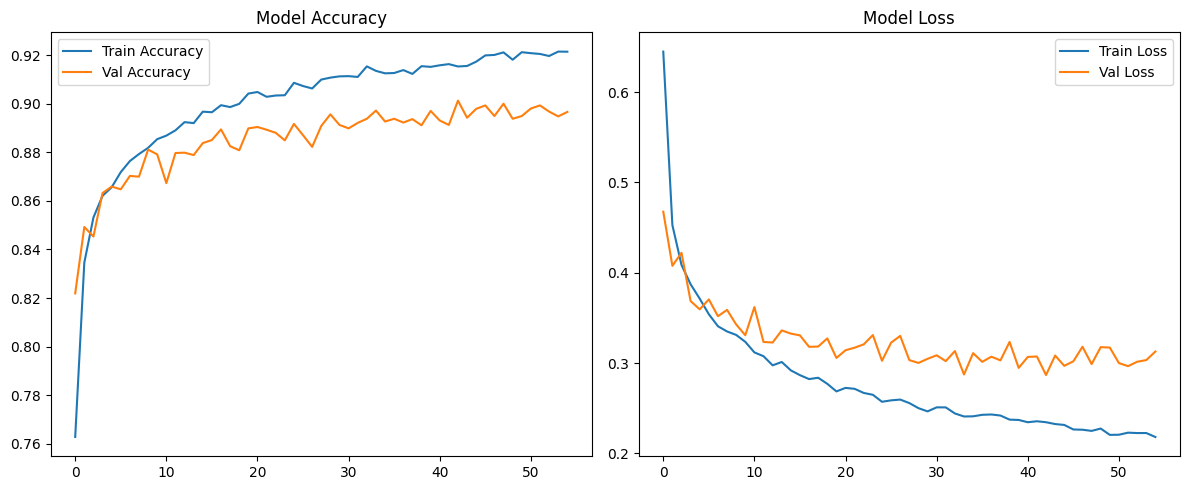

In [14]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [16]:
# ✅ Ensure validation generator doesn't shuffle (to match order)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 7092 images belonging to 4 classes.


In [17]:
# ✅ Predict on validation set
y_pred_probs = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred_probs, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# ✅ Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))


222/222 [==============================] - 16s 67ms/step
Classification Report:
              precision    recall  f1-score   support

         CNV       0.95      0.84      0.89      1773
         DME       0.95      0.90      0.92      1773
      DRUSEN       0.84      0.88      0.86      1773
      NORMAL       0.86      0.97      0.91      1773

    accuracy                           0.90      7092
   macro avg       0.90      0.90      0.90      7092
weighted avg       0.90      0.90      0.90      7092



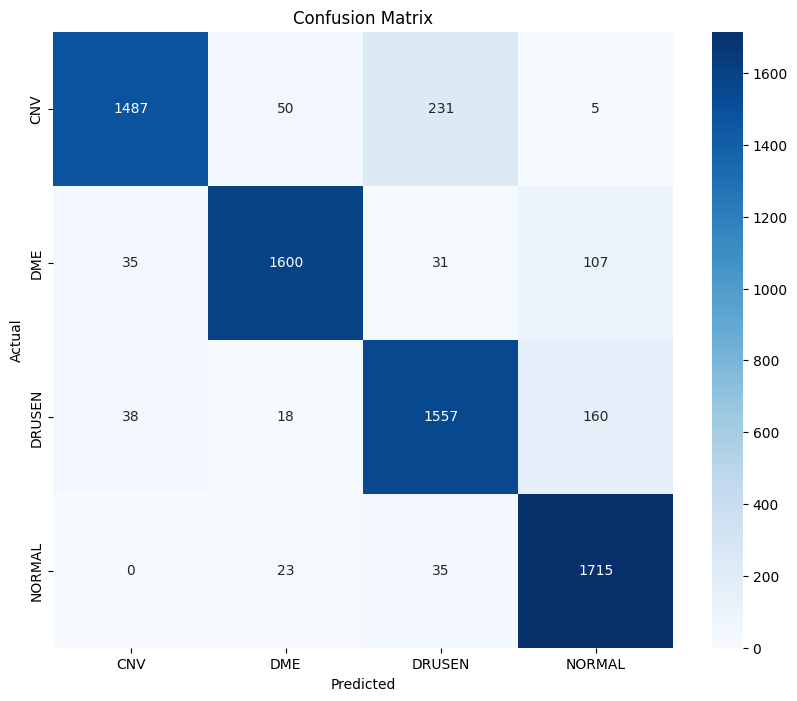

In [18]:
# ✅ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [19]:
import os
import pandas as pd

def prepare_dataframe(train_dir, val_dir):
    all_images = []
    all_labels = []

    for folder in [train_dir, val_dir]:
        for class_name in os.listdir(folder):
            class_path = os.path.join(folder, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    all_images.append(os.path.join(class_path, img_name))
                    all_labels.append(class_name)

    df = pd.DataFrame({'filename': all_images, 'label': all_labels})
    return df

# 🔁 Merge train and val
df = prepare_dataframe(train_dir, val_dir)
print(df.head())


                                  filename label
0    balanced_train\CNV\CNV-1016042-1.jpeg   CNV
1   balanced_train\CNV\CNV-1016042-10.jpeg   CNV
2  balanced_train\CNV\CNV-1016042-100.jpeg   CNV
3  balanced_train\CNV\CNV-1016042-101.jpeg   CNV
4  balanced_train\CNV\CNV-1016042-102.jpeg   CNV


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import clone_model
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Constants
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
N_SPLITS = 5

# Create StratifiedKFold
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Labels
class_labels = sorted(df['label'].unique())
all_reports = []

# Image Augmentation
train_aug = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.15,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_aug = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input
)

# Model creation function
def create_model():
    base_model = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
    base_model.trainable = False  # Freeze base
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(len(class_labels), activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Cross-validation training
for fold, (train_idx, val_idx) in enumerate(skf.split(df['filename'], df['label']), 1):
    print(f"\n🔄 Fold {fold}")
    
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_gen = train_aug.flow_from_dataframe(
        train_df, x_col='filename', y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_gen = val_aug.flow_from_dataframe(
        val_df, x_col='filename', y_col='label',
        target_size=(IMG_SIZE, IMG_SIZE),
        class_mode='categorical',
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    model = create_model()

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2)

    # Train
    model.fit(train_gen, epochs=EPOCHS, validation_data=val_gen, callbacks=[early_stop, reduce_lr])

    # Evaluate
    y_probs = model.predict(val_gen)
    y_preds = np.argmax(y_probs, axis=1)
    y_true = val_gen.classes

    report = classification_report(y_true, y_preds, target_names=class_labels, output_dict=True)
    all_reports.append(report)

# Optional: Average performance across all folds
average_accuracy = np.mean([r['accuracy'] for r in all_reports])
print(f"\n✅ Average Cross-Validation Accuracy: {average_accuracy:.4f}")



🔄 Fold 1
Found 25532 validated image filenames belonging to 4 classes.
Found 6384 validated image filenames belonging to 4 classes.
Epoch 1/30
798/798 [==============================] - 202s 249ms/step - loss: 0.6507 - accuracy: 0.7439 - val_loss: 0.5183 - val_accuracy: 0.8039 - lr: 0.0010
Epoch 2/30
798/798 [==============================] - 198s 248ms/step - loss: 0.5218 - accuracy: 0.8020 - val_loss: 0.4833 - val_accuracy: 0.8152 - lr: 0.0010
Epoch 3/30
798/798 [==============================] - 196s 245ms/step - loss: 0.4990 - accuracy: 0.8096 - val_loss: 0.4168 - val_accuracy: 0.8360 - lr: 0.0010
Epoch 4/30
798/798 [==============================] - 197s 247ms/step - loss: 0.4740 - accuracy: 0.8182 - val_loss: 0.4123 - val_accuracy: 0.8426 - lr: 0.0010
Epoch 5/30
798/798 [==============================] - 196s 245ms/step - loss: 0.4678 - accuracy: 0.8219 - val_loss: 0.3868 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 6/30
798/798 [==============================] - 199s 249ms/step - 

In [21]:
# Average accuracy, precision, recall, F1-score
summary = {}
for cls in class_labels:
    precision = np.mean([fold[cls]['precision'] for fold in all_reports])
    recall = np.mean([fold[cls]['recall'] for fold in all_reports])
    f1 = np.mean([fold[cls]['f1-score'] for fold in all_reports])
    summary[cls] = {'Precision': precision, 'Recall': recall, 'F1-Score': f1}

# Display summary
pd.DataFrame(summary).T


,Precision,Recall,F1-Score
CNV,0.894557,0.910016,0.902201
DME,0.912969,0.917533,0.915195
DRUSEN,0.874309,0.783306,0.826119
NORMAL,0.863633,0.933450,0.897046


In [39]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input

# Path to the test image
img_path = "Dataset - train+val+test/test/DRUSEN/DRUSEN-64262-1.jpeg"  # 👈 Replace with your image path

# Load and preprocess the image
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array = preprocess_input(img_array)        # Normalize


In [40]:
# Make prediction
predictions = model.predict(img_array)
predicted_class_index = np.argmax(predictions[0])
confidence = np.max(predictions[0])


1/1 [==============================] - 0s 89ms/step


In [41]:
# Get class label mapping
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

predicted_class_name = class_names[predicted_class_index]

print(f"Predicted class: {predicted_class_name} (Confidence: {confidence:.2f})")


Predicted class: DRUSEN (Confidence: 0.97)
